In [0]:
import os
import numpy as np
import glob
import shutil

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense, Conv2D, Flatten, Dropout, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

In [0]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL,
                                   fname="flower_photos.tgz",
                                   extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

In [62]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

roses: 641 Images
daisy: 633 Images
dandelion: 898 Images
sunflowers: 699 Images
tulips: 799 Images


In [63]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

for cl in classes:
  img_path = os.path.join(train_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  



roses: 513 Images
daisy: 506 Images
dandelion: 718 Images
sunflowers: 559 Images
tulips: 639 Images


In [0]:
batch_size=32
img_shape=(224,224,3)
IMG_SHAPE=224

In [47]:
#augumentation
image_gen = ImageDataGenerator(rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
)

train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                    class_mode='categorical'

                                                     )




image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen =  image_gen_val.flow_from_directory(batch_size=batch_size,
                                                     directory=val_dir,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                   class_mode='categorical'
                                                    )



Found 2935 images belonging to 5 classes.
Found 735 images belonging to 5 classes.


In [0]:
base_mobile1 = tf.keras.applications.MobileNetV2(input_shape=img_shape, include_top=False, weights="imagenet")

In [49]:
base_mobile1.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [50]:
base_mobile1.input

<tf.Tensor 'input_4:0' shape=(None, 224, 224, 3) dtype=float32>

In [0]:
for layer in base_mobile1.layers:
  layer.trainable=False

In [0]:


x = base_mobile1.output
x= GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
out = Dense(5, activation='softmax')(x)

complete_mobiledense = Model(base_mobile1.input, out)
complete_mobiledense.compile(optimizer='adam', loss='categorical_crossentropy',metrics=["accuracy"])  


In [0]:
complete_mobiledense.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [0]:
epoch=20

history = complete_mobiledense.fit_generator(train_data_gen,
                    epochs=epoch,
                        steps_per_epoch=int(np.ceil(2935 / float(batch_size))),

                    validation_data=val_data_gen,
                        validation_steps=int(np.ceil(735 / float(batch_size)))

)

Epoch 1/20
92/92 [==============================] - 40s 437ms/step - loss: 0.7222 - accuracy: 0.7325 - val_loss: 0.3976 - val_accuracy: 0.8585
Epoch 2/20
92/92 [==============================] - 40s 431ms/step - loss: 0.4606 - accuracy: 0.8358 - val_loss: 0.3996 - val_accuracy: 0.8612
Epoch 3/20
92/92 [==============================] - 39s 428ms/step - loss: 0.4069 - accuracy: 0.8613 - val_loss: 0.3403 - val_accuracy: 0.8735
Epoch 4/20
92/92 [==============================] - 39s 427ms/step - loss: 0.3770 - accuracy: 0.8613 - val_loss: 0.3539 - val_accuracy: 0.8748
Epoch 5/20
92/92 [==============================] - 40s 431ms/step - loss: 0.3436 - accuracy: 0.8695 - val_loss: 0.3309 - val_accuracy: 0.8816
Epoch 6/20
92/92 [==============================] - 39s 426ms/step - loss: 0.3336 - accuracy: 0.8770 - val_loss: 0.3474 - val_accuracy: 0.8803
Epoch 7/20
92/92 [==============================] - 40s 429ms/step - loss: 0.3275 - accuracy: 0.8828 - val_loss: 0.3387 - val_accuracy: 0.8721

<Figure size 576x576 with 0 Axes>

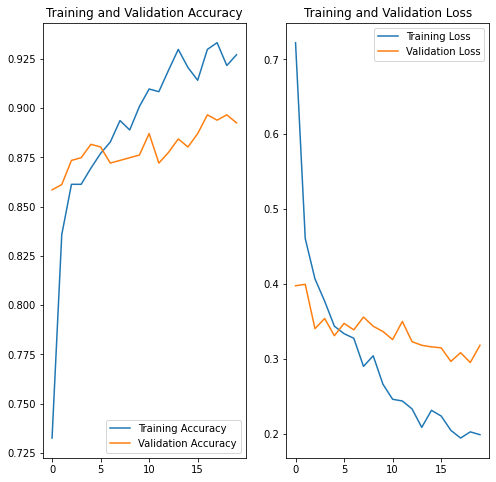

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


epochs_range = range(20)
plt.figure(figsize=(8, 8))



plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')



plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**With L2 regularization**

In [0]:

x = base_mobile1.output
x= GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu',activity_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.2)(x)
out = Dense(5, activation='softmax',activity_regularizer=regularizers.l2(0.01))(x)

complete_mobiledense1 = Model(base_mobile1.input, out)
complete_mobiledense1.compile(optimizer='adam', loss='categorical_crossentropy',metrics=["accuracy"])  


In [0]:
complete_mobiledense1.summary()

In [0]:
epoch=20

history = complete_mobiledense1.fit_generator(train_data_gen,
                    epochs=epoch,
                        steps_per_epoch=int(np.ceil(2935 / float(batch_size))),

                    validation_data=val_data_gen,
                        validation_steps=int(np.ceil(735 / float(batch_size)))

)

Epoch 1/20
92/92 [==============================] - 41s 447ms/step - loss: 1.0776 - accuracy: 0.7284 - val_loss: 0.7761 - val_accuracy: 0.8612
Epoch 2/20
92/92 [==============================] - 40s 436ms/step - loss: 0.7895 - accuracy: 0.8273 - val_loss: 0.6590 - val_accuracy: 0.8816
Epoch 3/20
92/92 [==============================] - 40s 438ms/step - loss: 0.7202 - accuracy: 0.8433 - val_loss: 0.6348 - val_accuracy: 0.8694
Epoch 4/20
92/92 [==============================] - 40s 438ms/step - loss: 0.6573 - accuracy: 0.8658 - val_loss: 0.6067 - val_accuracy: 0.8735
Epoch 5/20
92/92 [==============================] - 40s 439ms/step - loss: 0.6257 - accuracy: 0.8634 - val_loss: 0.5667 - val_accuracy: 0.8830
Epoch 6/20
92/92 [==============================] - 40s 435ms/step - loss: 0.6013 - accuracy: 0.8654 - val_loss: 0.5604 - val_accuracy: 0.8735
Epoch 7/20
92/92 [==============================] - 40s 433ms/step - loss: 0.5841 - accuracy: 0.8685 - val_loss: 0.5118 - val_accuracy: 0.8871

In [64]:
sample_val_images, label = next(val_data_gen) 
predicted_batch = complete_mobiledense1.predict(sample_val_images)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
classes = np.array(['daisy','dandelion','roses','sunflowers', 'tulips'])
predicted_class_names = classes[predicted_ids]
print(predicted_class_names)


real_class=classes[np.argmax(label,axis=1)]

print(real_class)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'dandelion' 'sunflowers'
 'sunflowers' 'roses' 'tulips' 'daisy' 'tulips' 'roses' 'dandelion'
 'tulips' 'roses' 'sunflowers' 'daisy' 'tulips' 'roses' 'dandelion'
 'roses' 'roses' 'sunflowers' 'daisy' 'sunflowers' 'dandelion' 'roses'
 'roses' 'roses' 'tulips' 'dandelion' 'sunflowers']
['dandelion' 'daisy' 'tulips' 'sunflowers' 'dandelion' 'sunflowers'
 'sunflowers' 'roses' 'daisy' 'daisy' 'tulips' 'roses' 'dandelion'
 'tulips' 'roses' 'sunflowers' 'dandelion' 'tulips' 'roses' 'dandelion'
 'roses' 'tulips' 'sunflowers' 'daisy' 'sunflowers' 'dandelion' 'roses'
 'roses' 'tulips' 'tulips' 'dandelion' 'sunflowers']


Flowers with prediction


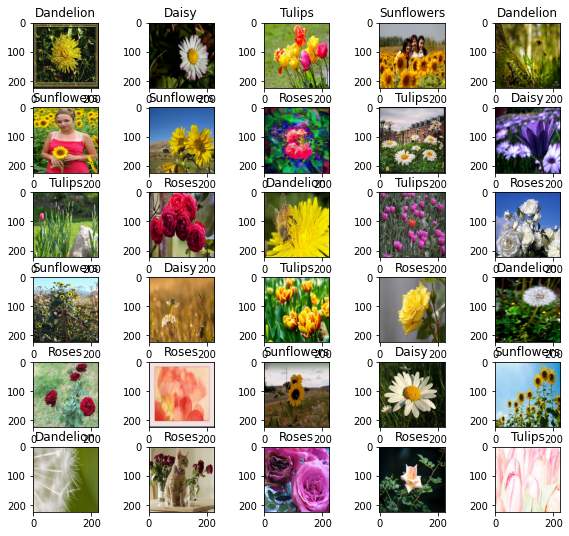

In [68]:
print("Flowers with prediction")
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(sample_val_images[n])
  plt.title(predicted_class_names[n].title())
